# Data preparation

What we do in this notebook:

#### Loading
* Read data from the Kaggle file `pairs.csv`.
* Take the subset of data with `df.country_1=="US"` and `df.country_2=="US"`.

#### Cleaning
* Replace missing string values with the empty string. (There is no missing values in the coordinates data.)
* Unify the `state` code into two letter format using the state code file `state-code.csv`.
* Throw away rows with the `state` codes that are not in `state-code.csv`.

#### Adding features
* For each pairs of feature in `[('latitude','longitude'),'name','address','city','state','zip','url','phone','categories']`.
  calculate the "difference" using two different metrics: 
     * straight line distance, great circle distance for ('latitude','longitude')
     * SequenceMatcher, Levinshtein, Cosine-similarity for other features
     
* Add a new column with name, depending on the metric used, in the following formats
    * `geo_diff` (straight line distance for ('latitude','longitude'))
    * `geo_theta_diff` (great circle distance for ('latitude','longitude'))
    * `<feature>_diff_seq`
    * `<feature>_diff_lev`
    * `<feature>_csim`
* Save the new dataframe into the file `pairs_us_diffs.csv`. Current size: 60M.
* At the end, we just take a very quick look at the corelation matrix of those "difference features".

---


# Data cleaning

In [1]:
import numpy as np
import pandas as pd

In [2]:
# read data from pairs.csv
# replace mypath to your local path of the file pairs.csv
mypath = "../data_raw/pairs.csv"
df_pairs  = pd.read_csv(mypath)

In [3]:
# consider only the US pairs
df_pairs_us = df_pairs[(df_pairs.country_1=='US') & (df_pairs.country_2=='US')].copy()

In [4]:
df = df_pairs_us.copy()
# reindexing the subset.
df.reset_index(drop=True, inplace=True)

In [5]:
# fill missing value with empty string.
df.fillna('', inplace=True)
# df.isna().sum()

In [6]:
import string
string_features = ['name_1', 'name_2',
                   'address_1', 'address_2', 
                   'city_1', 'city_2',
                   'state_1', 'state_2', 
                   'zip_1', 'zip_2',
                   'country_1', 'country_2', 
                   'url_1', 'url_2',
                   'phone_1', 'phone_2', 
                   'categories_1', 'categories_2']
position_features = ['latitude_1', 'latitude_2', 'longitude_1', 'longitude_2']

df[string_features] = df[string_features].fillna('').astype(str).apply(
    lambda x: x.str.lower().str.replace('[{}]'.format(string.punctuation),'',regex=True))
df[position_features] = df[position_features].astype('float64')
# df.head()

In [7]:
# two letter US state code from 
# https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm
# saved in state-code.csv
# Notes: Don't be confused with FIPS Code: 56 is not the total; some numbers are missing.

state = pd.read_csv('../data_raw/state-code.csv', header=None)
state.columns=['state','code']
state['state'] = state['state'].str.upper()
state.head()

,state,code
0,ALABAMA,AL
1,ALASKA,AK
2,ARIZONA,AZ
3,ARKANSAS,AR
4,CALIFORNIA,CA


In [8]:
# Unify the format of the state code

dict_lookup = dict(zip(state['state'],state['code']))
dict_lookup['CALIF']  = 'CA'
# dict_lookup['D.C.']   = 'DC'
dict_lookup['ONNY']  = 'NY'

df['state_1'] = df['state_1'].str.upper()
df['state_2'] = df['state_2'].str.upper()

for x in dict_lookup.keys():
    
    df.loc[df["state_1"] == x, "state_1"] = dict_lookup[x]
    df.loc[df["state_2"] == x, "state_2"] = dict_lookup[x]
    
print(df['state_1'].unique())
print(df['state_2'].unique())

['CA' 'GA' 'NM' 'FL' 'VA' 'TN' 'NJ' 'UT' 'IN' 'NC' 'WI' '' 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'MO' 'WV' 'CO'
 'NE' 'OH' 'OR' 'MT' 'CT' 'NH' 'MD' 'HI' 'WA' 'WY' 'RI' 'VT' 'IA' 'MN'
 'LA' 'SC' 'ND' 'DE' 'DC' 'SD' 'AK' 'ID' 'ME' 'CE']
['CA' 'GA' 'NM' 'FL' 'VA' 'TN' '' 'NJ' 'UT' 'IN' 'NC' 'WI' 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'WV' 'CO' 'NE'
 'OH' 'OR' 'MT' 'SC' 'CT' 'NH' 'MO' 'MD' 'HI' 'WA' 'WY' 'VT' 'IA' 'MN'
 'LA' 'ND' 'DE' 'DC' 'SD' 'AK' 'ID' 'ME' 'RI' 'UK' 'CE' 'NU' '国外']


In [9]:
print(set(df['state_1'].unique()).difference(set(state['code'])))
print(set(df['state_2'].unique()).difference(set(state['code'])))
S1 = set(df['state_1'].unique())
S2 = set(df['state_2'].unique())
S  = set(state['code'])
drop_list = S1.union(S2).difference(S)
print(drop_list)
drop_list.remove('')
print(drop_list) # drop_list = ['UK', 'CE', 'NU', '国外']

{'', 'CE'}
{'', 'CE', 'NU', '国外', 'UK'}
{'', 'CE', 'NU', '国外', 'UK'}
{'CE', 'NU', '国外', 'UK'}


In [10]:
df = df[df['state_1'].isin(drop_list)==False] 
df = df[df['state_2'].isin(drop_list)==False] 
print(df['state_1'].unique())
print(df['state_2'].unique())
tmp1 = df['state_1'].unique()
tmp2 = df['state_2'].unique()
print(set(state['code']).difference(set(tmp1)))
print(set(state['code']).difference(set(tmp2)))
print(df.shape)

['CA' 'GA' 'NM' 'FL' 'VA' 'TN' 'NJ' 'UT' 'IN' 'NC' 'WI' '' 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'MO' 'WV' 'CO'
 'NE' 'OH' 'OR' 'MT' 'CT' 'NH' 'MD' 'HI' 'WA' 'WY' 'RI' 'VT' 'IA' 'MN'
 'LA' 'SC' 'ND' 'DE' 'DC' 'SD' 'AK' 'ID' 'ME']
['CA' 'GA' 'NM' 'FL' 'VA' 'TN' '' 'NJ' 'UT' 'IN' 'NC' 'WI' 'NV' 'KS' 'MA'
 'MS' 'AZ' 'MI' 'NY' 'TX' 'IL' 'AL' 'PA' 'OK' 'AR' 'KY' 'WV' 'CO' 'NE'
 'OH' 'OR' 'MT' 'SC' 'CT' 'NH' 'MO' 'MD' 'HI' 'WA' 'WY' 'VT' 'IA' 'MN'
 'LA' 'ND' 'DE' 'DC' 'SD' 'AK' 'ID' 'ME' 'RI']
{'VI', 'PR'}
{'VI', 'PR'}
(117703, 25)


# Computing "difference/similarity"

 Computing "difference/similarity" of various features and adding the difference as new columns 

In [11]:
def get_diff(df,func,*feature,name=None,sim=None):
    '''Get difference of given feature using input metric
    
    df:      data frame of pairs
    func:    metric to apply
    feature: features to compare with the metric
    name:    new feature name
    
    '''
    if name is None:
        name = feature[0]+'_diff'
    if sim is None:
        sim = 'difference'
    else:
        sim = 'similarity'
    
    print('Getting {} in {} with the "{}" metric.'.format(sim,feature,func.__name__))
    
    print('Making new column "{}"'.format(name))
    print()
    cols = [str(x)+'_1' for x in feature]+[str(x)+'_2' for x in feature]   
    df[name] = df[cols].apply(func, axis=1)


In [12]:
def l2_metric(pair):
    ''' Euclidean distance (l2) for comparing geographic coordinates
    
    '''
    a = np.asarray(pair[0],pair[1])
    b = np.asarray(pair[2],pair[3])
    return np.linalg.norm(a-b)

In [13]:
from difflib import SequenceMatcher
def seq_metric(pair):
    ''' metric for comparing strings
    
    '''
    a,b = tuple(pair)
    if type(a)!=str or type(b)!=str:
        return -1
    else:
        # from Ling.
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
        # b = b.lower().replace('[{}]'.format(string.punctuation),'').replace(" ", "")
    return 1-SequenceMatcher(None, a, b).ratio()


In [14]:
from Levenshtein import distance as lev
def lev_metric(pair):
    ''' Levenshtein metric for comparing strings
    
    '''
    a,b = tuple(pair)
    if type(a)!=str or type(b)!=str:
        return -1
    elif len(a)==0 or len(b)==0:
        return -1
    else:
        a = a.lower().replace(" ", "").replace("'", "")
        b = b.lower().replace(" ", "").replace("'", "")
    return lev(a,b)/max(len(a),len(b))

In [15]:
print(df.columns.values)
print()

feature = ('latitude','longitude')
get_diff(df,l2_metric,*feature,name='geo_diff')

features = ['name','address','city','state','zip','url','phone','categories']
features = [[x] for x in features]
for feature in features:
    get_diff(df,seq_metric,*feature,name=feature[0]+'_diff_seq')
    get_diff(df,lev_metric,*feature,name=feature[0]+'_diff_lev')
print(df.columns.values)

['id_1' 'name_1' 'latitude_1' 'longitude_1' 'address_1' 'city_1' 'state_1'
 'zip_1' 'country_1' 'url_1' 'phone_1' 'categories_1' 'id_2' 'name_2'
 'latitude_2' 'longitude_2' 'address_2' 'city_2' 'state_2' 'zip_2'
 'country_2' 'url_2' 'phone_2' 'categories_2' 'match']

Getting difference in ('latitude', 'longitude') with the "l2_metric" metric.
Making new column "geo_diff"

Getting difference in ('name',) with the "seq_metric" metric.
Making new column "name_diff_seq"

Getting difference in ('name',) with the "lev_metric" metric.
Making new column "name_diff_lev"

Getting difference in ('address',) with the "seq_metric" metric.
Making new column "address_diff_seq"

Getting difference in ('address',) with the "lev_metric" metric.
Making new column "address_diff_lev"

Getting difference in ('city',) with the "seq_metric" metric.
Making new column "city_diff_seq"

Getting difference in ('city',) with the "lev_metric" metric.
Making new column "city_diff_lev"

Getting difference in ('state',

In [16]:
def theta_diff(pair):
    ''' Great circle distance for geographic coordinates
    
    https://en.wikipedia.org/wiki/Great-circle_distance#Computational_formulas
    
    '''
    PI = np.pi
    
    phi_1, phi_2 = pair[0], pair[1] #latitudes
    lam_1, lam_2 = pair[2], pair[3] #longitudes
    
    # convert to radians for calculation:
    for x in [phi_1,phi_2,lam_1,lam_2]:
        x = np.deg2rad(x)
    
    del_lam = lam_1 - lam_2
    
    p = np.cos(phi_2)*np.sin(del_lam)
    q = np.cos(phi_1)*np.sin(phi_2) - np.sin(phi_1)*np.cos(phi_2)*np.cos(del_lam)
    r = np.sin(phi_1)*np.sin(phi_2) + np.cos(phi_1)*np.cos(phi_2)*np.cos(del_lam)
    
    diff = np.arctan(np.sqrt(p**2+q**2)/r)
    
    return np.abs(diff)

In [17]:
feature = ('latitude','longitude')
get_diff(df,theta_diff,*feature,name='geo_theta_diff')

Getting difference in ('latitude', 'longitude') with the "theta_diff" metric.
Making new column "geo_theta_diff"



In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string

def cos_sim(pair):
    ''' cosine_sim metric for comparing strings
    
    '''
    a,b = tuple(pair)

    try:
        if (a == '') | (b == ''):
            csim = -1
        elif (a == ' ') | (b == ' '):
            csim = -1
        else:
            csim = cosine_similarity(CountVectorizer().fit_transform([a,b]).toarray())[0][1]
        return csim
    except ValueError:
        print(a,b)
        csim = -1
        return csim
    
features = ['name','address','city','state','zip','url','phone','categories']
features = [[x] for x in features]
for feature in features:
    get_diff(df,cos_sim,*feature,name=feature[0]+'_csim')
print(df.columns.values)

Getting difference in ('name',) with the "cos_sim" metric.
Making new column "name_csim"

Getting difference in ('address',) with the "cos_sim" metric.
Making new column "address_csim"

1 1
n 
Getting difference in ('city',) with the "cos_sim" metric.
Making new column "city_csim"

1 1
Getting difference in ('state',) with the "cos_sim" metric.
Making new column "state_csim"

Getting difference in ('zip',) with the "cos_sim" metric.
Making new column "zip_csim"

Getting difference in ('url',) with the "cos_sim" metric.
Making new column "url_csim"

Getting difference in ('phone',) with the "cos_sim" metric.
Making new column "phone_csim"

0 0
Getting difference in ('categories',) with the "cos_sim" metric.
Making new column "categories_csim"

['id_1' 'name_1' 'latitude_1' 'longitude_1' 'address_1' 'city_1' 'state_1'
 'zip_1' 'country_1' 'url_1' 'phone_1' 'categories_1' 'id_2' 'name_2'
 'latitude_2' 'longitude_2' 'address_2' 'city_2' 'state_2' 'zip_2'
 'country_2' 'url_2' 'phone_2' 'ca

In [19]:
# df.isna().sum()

In [20]:
df.to_csv('./data/pairs_us_diffs.csv')


In [21]:
# show size of the file
%ls -lh ./data/pairs_us_diffs.csv

-rw-r--r--  1 cao20  staff    60M Jun  2 16:01 ./data/pairs_us_diffs.csv


---

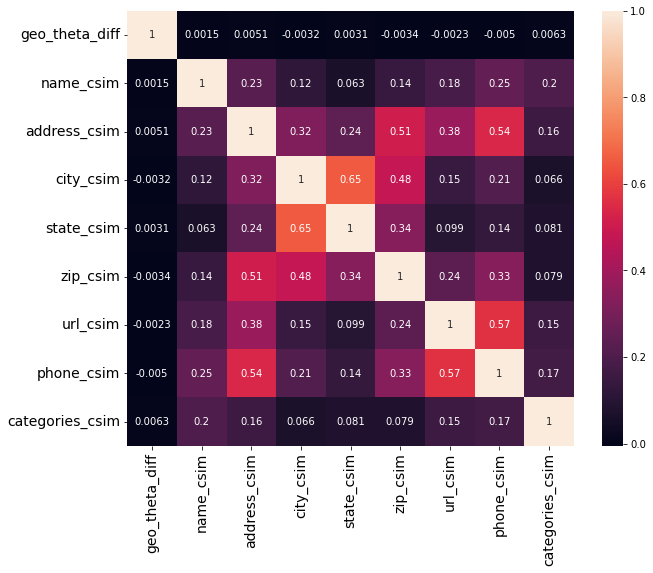

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.iloc[:,-9:].corr(), annot=True, ax=ax)
ax.tick_params(axis='both',labelsize=14)
plt.show()

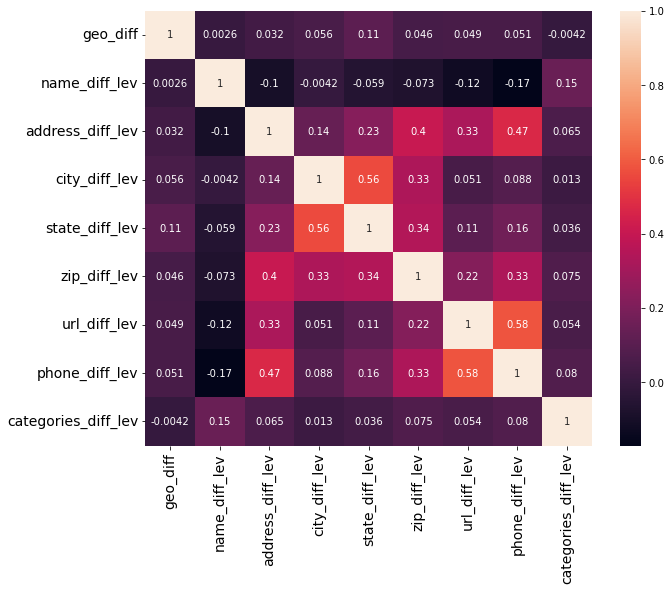

In [23]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.iloc[:,-26:-9:2].corr(), annot=True, ax=ax)
ax.tick_params(axis='both',labelsize=14)
plt.show()

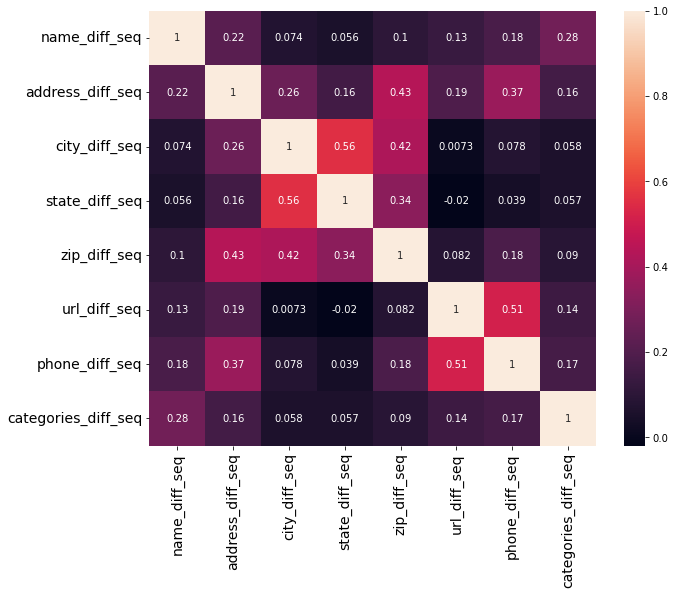

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.iloc[:,-25:-10:2].corr(), annot=True, ax=ax)
ax.tick_params(axis='both',labelsize=14)
plt.show()